In [1]:
import pandas as pd
import numpy as np
!pip install st_dbscan
from st_dbscan import ST_DBSCAN
from datetime import datetime
import time
import matplotlib.pyplot as plt
import os
import geopandas as gpd
import pandas as pd
from sklearn.cluster import DBSCAN
import seaborn as sns
from itertools import product
from sklearn.preprocessing import MinMaxScaler
import sys
sys.path.insert(0, "src")
from ST_Cluster import *
import numpy as np
import pandas as pd
from sklearn.neighbors import BallTree

/srv/conda/envs/notebook/lib/python3.12/site-packages/st_dbscan/__init__.py:2: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution, DistributionNotFound


In [2]:
def split_by_temporal_gaps(claims: pd.DataFrame, time_thres: int):
    """
    Identify long gaps (no claims) in the dataset and split accordingly.

    Args
    ----
    claims : DataFrame with a 'daysSinceStart' column (int).
    time_thres : int, threshold (days) used for temporal clustering.

    Returns
    -------
    splits : list of DataFrames, contiguous subframes with no gaps > time_thres.
    gap_count : int, number of such gaps.
    gap_points : list of day indices where gaps occur.
    sizes : list[int], number of rows in each split.
    """
    claims = claims.sort_values('daysSinceStart').reset_index(drop=True)

    diffs = claims['daysSinceStart'].diff().fillna(0).astype(int)
    gap_mask = diffs > time_thres
    split_idx = np.where(gap_mask)[0]

    splits, sizes, gap_points = [], [], []
    start = 0
    for idx in split_idx:
        sub = claims.iloc[start:idx].copy()
        splits.append(sub)
        sizes.append(len(sub))
        gap_points.append(int(claims.loc[idx, 'daysSinceStart']))
        start = idx
    sub = claims.iloc[start:].copy()
    splits.append(sub)
    sizes.append(len(sub))

    return splits, len(split_idx), gap_points, sizes

In [3]:
def cluster_temporal_by_county_for_splits(splits, time_thres: int, num_thres: int, label_col="temporal_cluster"):
    """
    For each split DataFrame:
      - run DBSCAN per county on 'daysSinceStart' (1D),
      - write labels to `label_col`,
      - compute stats: total rows, # temporal clusters (excluding -1), # of -1 rows.
    Returns:
      split_results: list of split DataFrames (with labels added)
      stats_df: DataFrame with per-split summary
    """
    split_results = []
    stats = []

    for si, df in enumerate(splits, start=1):
        if df.empty:
            stats.append({"split": si, "rows": 0, "temporal_clusters": 0, "noise_rows": 0})
            split_results.append(df.copy())
            print(f"Split {si}: 0 rows, 0 temporal clusters, 0 noise")
            continue

        sub = df.copy()
        sub[label_col] = -1  # init

        # DBSCAN per county
        for county in sub['countyCode'].dropna().unique():
            idx = sub.index[sub['countyCode'] == county]
            if len(idx) == 0:
                continue
            x = sub.loc[idx, ['daysSinceStart']].to_numpy()  # shape (n,1)

            db = DBSCAN(eps=time_thres, min_samples=num_thres, metric='euclidean')
            lbl = db.fit_predict(x)

            # write labels back
            sub.loc[idx, label_col] = lbl

        # stats
        n_rows = len(sub)
        noise_rows = int((sub[label_col] == -1).sum())

        # count clusters per county: unique (county, label>=0)
        if n_rows > 0:
            tmp = sub.loc[sub[label_col] >= 0, ['countyCode', label_col]]
            temporal_clusters = int(len(tmp.drop_duplicates()))
        else:
            temporal_clusters = 0

        print(f"Split {si}: {n_rows} rows, {temporal_clusters} temporal clusters, {noise_rows} noise")

        stats.append({
            "split": si,
            "rows": n_rows,
            "temporal_clusters": temporal_clusters,
            "noise_rows": noise_rows
        })
        split_results.append(sub)

    stats_df = pd.DataFrame(stats)
    return split_results, stats_df

In [4]:
def collect_temporal_cluster_lengths(split_results, label_col="temporal_cluster"):
    """
    Build a single Series of temporal cluster lengths (in days) across all splits.
    Length is defined as (max(daysSinceStart) - min(daysSinceStart)), no +1.
    Only counts labels >= 0 (i.e., excludes noise).
    """
    lengths = []
    for sub in split_results:
        if sub.empty or label_col not in sub.columns:
            continue
        # per (county, cluster) min/max of days
        g = (sub[sub[label_col] >= 0]
             .groupby(['countyCode', label_col])['daysSinceStart']
             .agg(['min', 'max']))
        if len(g) == 0:
            continue
        lengths.append((g['max'] - g['min']).astype('int32'))
    if not lengths:
        return pd.Series([], dtype='int32', name='cluster_length_days')
    out = pd.concat(lengths, ignore_index=True)
    out.name = 'cluster_length_days'
    return out

def plot_cluster_length_pdf(lengths: pd.Series, bins='auto', title='Temporal cluster length PDF (days)'):
    """
    Plot a normalized histogram (PDF) of cluster lengths using matplotlib.
    """
    if lengths.empty:
        print("[plot_cluster_length_pdf] No cluster lengths to plot.")
        return
    plt.figure(figsize=(7,4))
    plt.hist(lengths.values, bins=bins, density=True, edgecolor='black')
    plt.xlabel('Cluster length (days)')
    plt.ylabel('Density')
    plt.title(title)
    plt.tight_layout()
    plt.show()

In [5]:
def monthly_series_from_splits(split_results, label_col="temporal_cluster", date_col="date"):
    """
    Returns two monthly Series (indexed by month-start timestamps):
      - clusters_per_month
      - unclustered_claims_per_month
    """
    cluster_month_counts = []
    unclustered_month_counts = []
    all_dates_min, all_dates_max = None, None

    for sub in split_results:
        if sub.empty: 
            continue
        df = sub.copy()
        df[date_col] = pd.to_datetime(df[date_col])
        # Track global date span
        cur_min, cur_max = df[date_col].min(), df[date_col].max()
        all_dates_min = cur_min if all_dates_min is None else min(all_dates_min, cur_min)
        all_dates_max = cur_max if all_dates_max is None else max(all_dates_max, cur_max)
        df['month'] = df[date_col].dt.to_period('M').dt.to_timestamp()

        # (1) Clusters per month: assign each (county, cluster_id) to its median date's month
        clustered = df[df[label_col] >= 0]
        if not clustered.empty:
            per_cluster = clustered.groupby(['countyCode', label_col])[date_col].median().reset_index()
            per_cluster['month'] = per_cluster[date_col].dt.to_period('M').dt.to_timestamp()
            cm = per_cluster.groupby('month').size()
            cluster_month_counts.append(cm)

        # (2) Unclustered claims per month: count rows with label -1
        noise = df[df[label_col] == -1]
        if not noise.empty:
            um = noise.groupby('month').size()
            unclustered_month_counts.append(um)

    # Combine across splits
    clusters = (pd.concat(cluster_month_counts, axis=0).groupby(level=0).sum()
                if cluster_month_counts else pd.Series(dtype='int64'))
    unclustered = (pd.concat(unclustered_month_counts, axis=0).groupby(level=0).sum()
                   if unclustered_month_counts else pd.Series(dtype='int64'))

    # Build complete monthly index and fill zeros
    if all_dates_min is not None:
        month_index = pd.date_range(all_dates_min.to_period('M').start_time,
                                    all_dates_max.to_period('M').start_time, freq='MS')
        clusters = clusters.reindex(month_index, fill_value=0).sort_index()
        unclustered = unclustered.reindex(month_index, fill_value=0).sort_index()

    clusters.name = 'clusters_per_month'
    unclustered.name = 'unclustered_claims_per_month'
    return clusters, unclustered

In [6]:
def build_proxy_points_for_splits_cluster_only(split_results, time_thres: int, 
                                               label_col="temporal_cluster", date_col="date"):
    proxy_frames = []

    for si, sub in enumerate(split_results, start=1):
        if sub.empty:
            print(f"Split {si}: 0 rows")
            proxy_frames.append(pd.DataFrame(
                columns=['countyCode','latitude','longitude','date','daysSinceStart','original_temporal_cluster']
            ))
            continue

        sub = sub.copy()
        sub[date_col] = pd.to_datetime(sub[date_col])  # no normalize
        origin_date = sub[date_col].iloc[0] - pd.to_timedelta(int(sub['daysSinceStart'].iloc[0]), unit='D')

        clustered = sub[sub[label_col] >= 0]
        proxy_rows = []

        if not clustered.empty:
            g = clustered.groupby(['countyCode', label_col], sort=False)
            for (cc, tc), grp in g:
                tmin = int(grp['daysSinceStart'].min())
                tmax = int(grp['daysSinceStart'].max())
                med_lat = float(grp['latitude'].median())
                med_lon = float(grp['longitude'].median())

                times = list(range(tmin, tmax + 1, time_thres))
                if times[-1] != tmax:
                    times.append(tmax)

                for t in times:
                    proxy_rows.append({
                        'countyCode': cc,
                        'latitude':  med_lat,
                        'longitude': med_lon,
                        'date':      origin_date + pd.to_timedelta(int(t), unit='D'),
                        'daysSinceStart': int(t),
                        'original_temporal_cluster': int(tc)
                    })

        proxy_df = pd.DataFrame(
            proxy_rows,
            columns=['countyCode','latitude','longitude','date','daysSinceStart','original_temporal_cluster']
        )

        if not proxy_df.empty:
            proxy_df.sort_values('date', inplace=True, kind='mergesort')
            proxy_df.reset_index(drop=True, inplace=True)

        # sanity check so we catch this early if it regresses
        if not proxy_df.empty:
            assert 'countyCode' in proxy_df.columns, "countyCode missing from proxy_df!"

        print(f"Split {si}: {len(proxy_df)} rows")
        proxy_frames.append(proxy_df)

    return proxy_frames

In [7]:
def run_stdbscan_on_proxy_splits(proxy_frames,
                                 space_thres_list=[3],
                                 time_thres_list=[5],
                                 num_thres_list=[2],
                                 lat_col='latitude',
                                 lon_col='longitude',
                                 day_col='daysSinceStart',
                                 county_col='countyCode',
                                 temp_col='original_temporal_cluster'):
    """
    Run ST_DBSCAN on each split's proxy points using features [daysSinceStart, lat, lon].
    Adds columns like 'st_cluster_3_5_2' to each proxy frame (countyCode is preserved).
    """
    results = []
    updated = []

    for pf_idx, df in enumerate(proxy_frames, start=1):
        sub = df.copy()

        # --- sanity checks so we never “lose” countyCode ---
        required = [lat_col, lon_col, day_col, county_col, temp_col]
        missing = [c for c in required if c not in sub.columns]
        if missing:
            raise ValueError(f"Proxy split {pf_idx} missing columns: {missing}. "
                             f"Make sure your proxy builder includes {required}.")

        if sub.empty:
            updated.append(sub)
            continue

        # numeric arrays — no date normalization; use daysSinceStart directly
        t_days = pd.to_numeric(sub[day_col], errors='coerce').astype('float32')
        lat    = pd.to_numeric(sub[lat_col], errors='coerce').astype('float32')
        lon    = pd.to_numeric(sub[lon_col], errors='coerce').astype('float32')

        base_data = np.column_stack([t_days.to_numpy(), lat.to_numpy(), lon.to_numpy()]).astype('float32')

        # keep full frame (including countyCode); we'll just add label columns
        updated.append(sub)

        for space in space_thres_list:
            for time_eps in time_thres_list:
                for min_samp in num_thres_list:
                    st = ST_DBSCAN(eps1=space, eps2=time_eps, min_samples=min_samp)
                    st.fit(base_data)
                    labels = getattr(st, 'labels_', getattr(st, 'labels', None))
                    if labels is None:
                        raise RuntimeError("ST_DBSCAN did not expose labels or labels_")

                    col = f"st_cluster_{space}_{time_eps}_{min_samp}"
                    updated[-1][col] = labels.astype('int32')

                    n_clust = int(len(np.unique(labels[labels >= 0])))
                    print(f"(space={space}, time={time_eps}, min={min_samp}) — Split {pf_idx}: {n_clust} clusters")
                    results.append({
                        'space_thres': space,
                        'time_thres': time_eps,
                        'num_thres': min_samp,
                        'split': pf_idx,
                        'n_clusters': n_clust
                    })

    summary = pd.DataFrame(results)
    if not summary.empty:
        totals = (summary.groupby(['space_thres','time_thres','num_thres'], as_index=False)['n_clusters']
                         .sum()
                         .rename(columns={'n_clusters':'total_clusters_across_splits'}))
        for _, r in totals.iterrows():
            print(f"TOTAL (space={r.space_thres}, time={r.time_thres}, min={r.num_thres}): "
                  f"{int(r.total_clusters_across_splits)} clusters across splits")
    else:
        totals = pd.DataFrame(columns=['space_thres','time_thres','num_thres','total_clusters_across_splits'])

    return updated, summary, totals

In [8]:
def add_split_id_to_splits(splits):
    """Annotate each split DataFrame with a split_id column for clarity."""
    out = []
    for si, df in enumerate(splits, start=1):
        d = df.copy()
        d['split_id'] = si
        out.append(d)
    return out

def make_temporal_global_ids(split_results, county_col='countyCode',
                             temp_col='temporal_cluster', new_col='temporal_cluster_gid'):
    """
    For each split: for every (countyCode, temporal_cluster>=0) assign a unique global id.
    Writes `new_col` to each split; noise stays -1.
    """
    gid = 0
    updated = []
    for df in split_results:
        d = df.copy()
        d[new_col] = -1
        if not d.empty and temp_col in d.columns and county_col in d.columns:
            keys = (d.loc[d[temp_col] >= 0, [county_col, temp_col]]
                      .drop_duplicates()
                      .sort_values([county_col, temp_col]))
            key_to_gid = {}
            for _, row in keys.iterrows():
                key = (row[county_col], int(row[temp_col]))
                if key not in key_to_gid:
                    key_to_gid[key] = gid
                    gid += 1
            mask = d[temp_col] >= 0
            d.loc[mask, new_col] = d.loc[mask, [county_col, temp_col]].apply(
                lambda r: key_to_gid[(r[county_col], int(r[temp_col]))], axis=1
            ).astype('int32')
        updated.append(d)
    return updated

In [9]:
def ensure_proxy_seed_labels(
    proxy_frames,
    space_thres=3, time_thres=5, min_samples=2,
    county_col='countyCode', temp_col='original_temporal_cluster',
    st_col=None, out_col='st_seed', make_global=False
):
    """
    For each split's proxy frame:
      - If a temporal cluster has any ST label >= 0 → use the mode of those labels.
      - Else (all -1) → assign a new unique label.
    Writes the chosen label into `out_col` for every proxy row.
    If make_global=True, ensures uniqueness across splits (by offsetting).
    """
    if st_col is None:
        st_col = f"st_cluster_{space_thres}_{time_thres}_{min_samples}"

    updated = []
    next_global = 0  # for global uniqueness if requested

    for pf in proxy_frames:
        df = pf.copy()
        if df.empty or temp_col not in df.columns:
            df[out_col] = pd.Series([], dtype='int32')
            updated.append(df)
            continue

        # compute starting offset (per split) if not global
        used = df[st_col][df[st_col] >= 0]
        next_local = int(used.max()) + 1 if len(used) else 0

        # group by temporal cluster
        seeds = []
        for (cc, tc), grp in df.groupby([county_col, temp_col], sort=False):
            labels = grp[st_col].to_numpy()
            pos = labels[labels >= 0]
            if pos.size > 0:
                # mode among non-negative labels
                lab = int(pd.Series(pos).mode().iloc[0])
            else:
                # assign new id
                if make_global:
                    lab = next_global
                    next_global += 1
                else:
                    lab = next_local
                    next_local += 1
            # assign to group
            seeds.append(pd.DataFrame({
                county_col: [cc]*len(grp),
                temp_col:   [tc]*len(grp),
                out_col:    [lab]*len(grp)
            }, index=grp.index))

        if seeds:
            seed_df = pd.concat(seeds).sort_index()
            df[out_col] = seed_df[out_col].astype('int32')
        else:
            df[out_col] = np.int32(-1)

        updated.append(df)

    return updated

In [10]:
def make_global_st_ids(combined_frames, st_col='st_final', new_col='st_final_gid'):
    """
    Offset ST labels across splits so every st_final >=0 becomes globally unique.
    Writes `new_col` into each split; noise stays -1.
    """
    offset = 0
    updated = []
    for df in combined_frames:
        d = df.copy()
        if st_col not in d.columns or d.empty:
            d[new_col] = -1
            updated.append(d)
            continue
        labs = d[st_col].to_numpy()
        new = np.where(labs >= 0, labs + offset, -1).astype('int32')
        d[new_col] = new
        max_lab = labs[labs >= 0].max() if (labs >= 0).any() else -1
        offset += (max_lab + 1)
        updated.append(d)
    return updated

In [11]:
def attach_and_cluster_unclustered_splits_days(
    split_results,            # original per-split claims (must have 'daysSinceStart')
    proxy_frames_with_labels, # per-split proxy frames with 'daysSinceStart' and ST labels
    space_thres=3,            # degrees
    time_thres=5,             # days
    st_min_samples=2,         # used earlier for proxy clustering (for label col naming)
    unclustered_min_samples=7,
    st_label_col='st_seed',
    lat_col='latitude',
    lon_col='longitude',
    day_col='daysSinceStart',
    temp_label_col='temporal_cluster'
):
    """
    1) Seed clusters are the ST-DBSCAN labels on proxy points (min_samples=2).
    2) Attach unclustered original claims (temp_label_col == -1) to any seed cluster
       if within (space_thres, time_thres) of *any* proxy point in that cluster.
    3) Cluster the still-unattached unclustered claims with min_samples=7 (pure-unclustered).
    Returns per-split DataFrames with new column 'st_final' and a summary table.
    """
    if st_label_col is None:
        st_label_col = f"st_cluster_{space_thres}_{time_thres}_{st_min_samples}"

    eps_space_km  = space_thres * 111.0
    eps_space_rad = eps_space_km / EARTH_KM

    combined_frames = []
    summary_rows = []

    for si, (df, prox) in enumerate(zip(split_results, proxy_frames_with_labels), start=1):
        df = df.copy()
        prox = prox.copy()

        if df.empty:
            print(f"Split {si}: 0 rows → 0 clusters")
            combined_frames.append(df.assign(st_final=pd.Series([], dtype='int32')))
            summary_rows.append({"split": si, "rows": 0, "seed_clusters": 0,
                                 "attached_claims": 0, "new_pure_unclust_clusters": 0,
                                 "final_clusters": 0})
            continue

        # Sanity: ensure the needed columns are present
        for col in [lat_col, lon_col, day_col]:
            if col not in df.columns:
                raise ValueError(f"claims split missing column: {col}")
        for col in [lat_col, lon_col, day_col, st_label_col]:
            if col not in prox.columns:
                raise ValueError(f"proxy split missing column: {col}")

        # Seed clusters from proxy labels
        seed = prox.loc[:, [lat_col, lon_col, day_col, 'st_seed']].copy()
        seed = seed[seed['st_seed'] >= 0]
        n_seed = int(seed['st_seed'].nunique()) if not seed.empty else 0

        # Build spatial index over all proxy points (radians)
        if n_seed > 0:
            prox_coords_rad = np.deg2rad(seed[[lat_col, lon_col]].to_numpy(dtype='float64'))
            prox_tree = BallTree(prox_coords_rad, metric='haversine')
            prox_days = seed[day_col].to_numpy(dtype=np.int32)
            prox_labs = seed['st_seed'].to_numpy(dtype=np.int32)
        else:
            prox_tree = None

        # Output labels
        st_final = pd.Series(-1, index=df.index, dtype='int32')

        # Candidates = unclustered temporally
        cand_idx = df.index[df[temp_label_col] == -1]
        attached = 0

        if n_seed > 0 and len(cand_idx) > 0:
            cand = df.loc[cand_idx, [lat_col, lon_col, day_col]]
            cand_coords_rad = np.deg2rad(cand[[lat_col, lon_col]].to_numpy(dtype='float64'))
            # spatial neighbors from proxy points
            neighbors_arr = prox_tree.query_radius(cand_coords_rad, r=eps_space_rad)

            cand_days = cand[day_col].to_numpy(dtype=np.int32)

            for k, idx in enumerate(cand_idx):
                neigh = neighbors_arr[k]
                if neigh.size == 0:
                    continue
                # time filter on daysSinceStart (pure integers)
                ok_mask = np.abs(prox_days[neigh] - cand_days[k]) <= time_thres
                ok = neigh[ok_mask]
                if ok.size == 0:
                    continue
                # pick the first ok (they're already within spatial eps)
                best = ok[0]
                st_final.at[idx] = int(prox_labs[best])
                attached += 1

        # Still-unattached unclustered claims → pure-unclustered ST-DBSCAN (min_samples=7)
        remain_idx = df.index[(df[temp_label_col] == -1) & (st_final == -1)]
        new_clusters = 0
        if len(remain_idx) > 0:
            rem = df.loc[remain_idx, [lat_col, lon_col, day_col]].copy()
            # build features [time, lat, lon] using daysSinceStart directly
            data = np.column_stack([
                rem[day_col].to_numpy(dtype='float32'),
                rem[lat_col].to_numpy(dtype='float32'),
                rem[lon_col].to_numpy(dtype='float32')
            ])
            st2 = ST_DBSCAN(eps1=space_thres, eps2=time_thres, min_samples=unclustered_min_samples)
            st2.fit(data)
            lab2 = getattr(st2, 'labels_', getattr(st2, 'labels', None)).astype('int32')

            # Offset labels so they don't collide with existing seed labels
            if n_seed > 0:
                offset = int(seed[st_label_col].max()) + 1
            else:
                offset = 0
            pos = lab2 >= 0
            lab2[pos] = lab2[pos] + offset
            st_final.loc[remain_idx] = lab2

            new_clusters = int(len(np.unique(lab2[lab2 >= 0])))

        # Final reporting
        df['st_final'] = st_final
        final_clusters = int(df['st_final'].loc[df['st_final'] >= 0].nunique())

        print(f"Split {si}: seed={n_seed}, attached_claims={attached}, "
              f"new_pure_unclust_clusters={new_clusters}, final_clusters={final_clusters}")

        summary_rows.append({
            "split": si,
            "rows": int(len(df)),
            "seed_clusters": n_seed,
            "attached_claims": attached,
            "new_pure_unclust_clusters": new_clusters,
            "final_clusters": final_clusters
        })
        combined_frames.append(df)

    summary_df = pd.DataFrame(summary_rows)
    return combined_frames, summary_df

In [12]:
def map_final_labels_to_claims_by_id(
    claims,
    split_results,          # per-split claims with temporal_cluster and id
    proxy_frames,           # per-split proxies with countyCode, original_temporal_cluster and st_cluster_* label
    combined_frames,        # per-split claims with st_final (after attach + pure-unclustered)
    space_thres=3, time_thres=5, st_min_samples=2,  # to locate the proxy ST label column
    id_col='id', county_col='countyCode',
    temp_col='temporal_cluster',
    out_st_col='st_cluster_final'
):
    st_col = f"st_cluster_{space_thres}_{time_thres}_{st_min_samples}"

    per_split_maps = []
    for s_df, p_df, c_df in zip(split_results, proxy_frames, combined_frames):
        # Ensure required columns are present
        for col in [id_col, county_col, temp_col]:
            if col not in s_df.columns:
                raise ValueError(f"split_results missing column: {col}")
        if not p_df.empty and (st_col not in p_df.columns or 'original_temporal_cluster' not in p_df.columns or county_col not in p_df.columns):
            raise ValueError(f"proxy_frames must have [{county_col}, original_temporal_cluster, {st_col}]")
        if 'st_final' not in c_df.columns:
            raise ValueError("combined_frames must have 'st_final' column")

        # 2a) ST label per temporal cluster via proxies (mode over that cluster's proxy points)
        if not p_df.empty:
            p_mode = (
                p_df[p_df[st_col] >= 0]
                .groupby([county_col, 'original_temporal_cluster'])[st_col]
                .agg(lambda x: x.value_counts().idxmax())
                .reset_index()
                .rename(columns={'original_temporal_cluster': temp_col, st_col: 'st_from_proxy'})
            )
        else:
            p_mode = pd.DataFrame(columns=[county_col, temp_col, 'st_from_proxy'])

        # 2b) Start with per-claim rows for this split
        out = s_df[[id_col, county_col, temp_col]].copy()

        # Merge temporal-cluster → ST label (for temporally clustered rows)
        out = out.merge(p_mode, on=[county_col, temp_col], how='left')

        # 2c) Bring in st_final for unclustered rows (written during attach step)
        out = out.merge(c_df[[id_col, 'st_final']], on=id_col, how='left')

        # 2d) Choose final ST label:
        #    - if temporal_cluster >= 0 -> use st_from_proxy
        #    - else (temporal_cluster == -1) -> use st_final
        out[out_st_col] = np.where(out[temp_col] >= 0, out['st_from_proxy'], out['st_final'])
        out[out_st_col] = out[out_st_col].fillna(-1).astype('int32')

        # keep only needed columns to merge back to global claims
        per_split_maps.append(out[[id_col, temp_col, out_st_col]])

    # Concatenate all splits
    label_map = pd.concat(per_split_maps, ignore_index=True).drop_duplicates(id_col, keep='last')

    # Merge onto original claims by id
    out_claims = claims.merge(label_map, on=id_col, how='left')

    # Fill missing labels
    out_claims[temp_col] = out_claims[temp_col].fillna(-1).astype('int32')
    out_claims[out_st_col] = out_claims[out_st_col].fillna(-1).astype('int32')

    # sanity prints
    n = len(out_claims)
    print(f"Annotated {n} rows with temporal and ST labels.")
    print(f"  temporal_cluster >=0 on {(out_claims[temp_col] >= 0).sum()} rows")
    print(f"  {out_st_col} >=0 on {(out_claims[out_st_col] >= 0).sum()} rows")

    return out_claims

In [13]:
def assemble_cols(split_list, cols):
    parts = []
    for df in split_list:
        if df.empty: 
            continue
        need = [c for c in cols if c in df.columns]
        if need:
            parts.append(df[need].copy())
    return pd.concat(parts, ignore_index=True) if parts else pd.DataFrame(columns=cols)

In [14]:
def compute_st1st_map_for_split(proxy_df, space_thres, time_thres, min_samples,
                                county_col='countyCode', temp_gid_on_proxy='original_temporal_cluster'):
    st_col = f"st_cluster_{space_thres}_{time_thres}_{min_samples}"
    if st_col in proxy_df.columns and not proxy_df.empty:
        mode_proxy = (proxy_df[proxy_df[st_col] >= 0]
            .groupby([county_col, temp_gid_on_proxy])[st_col]
            .agg(lambda x: x.value_counts().idxmax())
            .reset_index()
            .rename(columns={st_col: 'st_from_proxy'}))
    else:
        mode_proxy = proxy_df[[county_col, temp_gid_on_proxy]].drop_duplicates()
        mode_proxy['st_from_proxy'] = pd.Series(dtype='float64')

    if 'st_seed' in proxy_df.columns and not proxy_df.empty:
        mode_seed = (proxy_df
            .groupby([county_col, temp_gid_on_proxy])['st_seed']
            .agg(lambda x: x.value_counts().idxmax())
            .reset_index()
            .rename(columns={'st_seed': 'st_from_seed'}))
    else:
        mode_seed = proxy_df[[county_col, temp_gid_on_proxy]].drop_duplicates()
        mode_seed['st_from_seed'] = pd.Series(dtype='float64')

    m = (mode_seed.merge(mode_proxy, on=[county_col, temp_gid_on_proxy], how='outer')
               .rename(columns={temp_gid_on_proxy: 'temporal_cluster_gid'}))
    m['st_cluster_1st'] = m['st_from_proxy'].fillna(m['st_from_seed']).astype('int32')
    return m[[county_col, 'temporal_cluster_gid', 'st_cluster_1st']]

def apply_st1st_to_split_claims(split_claims, st1st_map,
                                county_col='countyCode', temp_gid_col='temporal_cluster_gid'):
    out = split_claims.merge(st1st_map, on=[county_col, temp_gid_col], how='left')
    out['st_cluster_1st'] = out['st_cluster_1st'].fillna(-1).astype('int32')
    return out

def prepare_proxy_points_with_st1st(proxy_df, st1st_map,
                                    county_col='countyCode', temp_gid_on_proxy='original_temporal_cluster'):
    return (proxy_df.merge(st1st_map.rename(columns={'temporal_cluster_gid': temp_gid_on_proxy}),
                           on=[county_col, temp_gid_on_proxy], how='left')
                  .assign(st_cluster_1st=lambda d: d['st_cluster_1st'].fillna(-1).astype('int32')))

from sklearn.neighbors import BallTree
EARTH_KM = 6371.0088

def attach_unclustered_to_st1st_for_split(
    split_claims, proxy_df_with_st1st,
    space_thres, time_thres,
    lat_col='latitude', lon_col='longitude', day_col='daysSinceStart',
    temp_gid_col='temporal_cluster_gid'
):
    df = split_claims.copy()
    # clustered claims keep st_cluster_1st; unclustered start as -1
    st_final = np.where(df[temp_gid_col] >= 0, df['st_cluster_1st'], -1).astype('int32')

    prox = proxy_df_with_st1st.copy()
    prox = prox[prox['st_cluster_1st'] >= 0]
    if not prox.empty:
        prox_coords_rad = np.deg2rad(prox[[lat_col, lon_col]].to_numpy('float64'))
        prox_tree = BallTree(prox_coords_rad, metric='haversine')
        prox_days = prox[day_col].to_numpy('int32')
        prox_lab  = prox['st_cluster_1st'].to_numpy('int32')

        eps_space_rad = (space_thres * 111.0) / EARTH_KM

        # candidates = temporally unclustered claims
        cand_idx = df.index[df[temp_gid_col] == -1]
        if len(cand_idx) > 0:
            cand = df.loc[cand_idx, [lat_col, lon_col, day_col]]
            cand_coords_rad = np.deg2rad(cand[[lat_col, lon_col]].to_numpy('float64'))
            neighbors = prox_tree.query_radius(cand_coords_rad, r=eps_space_rad)
            cand_days = cand[day_col].to_numpy('int32')

            for k, idx in enumerate(cand_idx):
                neigh = neighbors[k]
                if neigh.size == 0:
                    continue
                ok = neigh[np.abs(prox_days[neigh] - cand_days[k]) <= time_thres]
                if ok.size == 0:
                    continue
                labs = prox_lab[ok]
                lab = int(pd.Series(labs).mode().iloc[0])  # stable choice
                st_final[idx] = lab

    df['st_cluster_final'] = st_final.astype('int32')
    return df

In [15]:
def print_cluster_totals_and_neg1(
    df: pd.DataFrame,
    temporal_col='temporal_cluster_gid',
    s1_col='st_cluster_1st_gid',
    sf_col='st_cluster_final_gid'
):
    def stats(col):
        if col not in df.columns:
            return 0, 0, 0.0
        s = df[col]
        n_clusters = s[s >= 0].nunique()
        n_neg1 = int((s == -1).sum())
        pct_neg1 = (n_neg1 / len(s) * 100.0) if len(s) else 0.0
        return n_clusters, n_neg1, pct_neg1

    n_t, m_t, p_t = stats(temporal_col)
    n_s1, m_s1, p_s1 = stats(s1_col)
    n_sf, m_sf, p_sf = stats(sf_col)

    print(f"Temporal clusters:        {n_t:>8} | -1 rows: {m_t:>10} ({p_t:5.2f}%)")
    print(f"ST clusters (1st pass):   {n_s1:>8} | -1 rows: {m_s1:>10} ({p_s1:5.2f}%)")
    print(f"ST clusters (final pass): {n_sf:>8} | -1 rows: {m_sf:>10} ({p_sf:5.2f}%)")

# Clustering Params

In [16]:
space_thres_list = [3]
time_thres_list = [5]
num_thres_list = [7]

# Create a folder for temporary files
temp_folder = "Clusters/2025_all"
os.makedirs(temp_folder, exist_ok=True)
damage_only = True

save = False
save_small=False

# Claims Data Load

In [17]:
# Load raw data
claims = pd.read_csv("../3_Failure_Modes/FimaNfipClaims_Aug2025.csv", low_memory=False)

## Preprocess

In [18]:
# Drop rows where 'dateOfLoss' is NA
claims = claims.dropna(subset=['dateOfLoss'])

# Drop rows where 'latitude' or 'longitude' is NA or blank
claims = claims.dropna(subset=['latitude', 'longitude'])
claims = claims[(claims['latitude'] != '') & (claims['longitude'] != '')]

# Remove rows where 'buildingDamageAmount' is less than 1
if damage_only:
    claims = claims[claims['buildingDamageAmount'] >= 1]

# Preprocess 'dateOfLoss' to numeric days
claims['dateOfLoss'] = pd.to_datetime(claims['dateOfLoss']).dt.tz_localize(None)
origin_date = claims['dateOfLoss'].min()
claims['daysSinceStart'] = (claims['dateOfLoss'] - origin_date).dt.days
claims['date'] = pd.to_datetime(claims['daysSinceStart'], unit='D', origin=origin_date)

# Create a unique index for each row
claims['index'] = claims.index

# Drop rows where 'countyCode' is NaN
claims = claims.dropna(subset=['countyCode'])

# Ensure that 'countyCode' is properly formatted as a 5-character string
claims['countyCode'] = claims['countyCode'].astype(int).astype(str)
claims['countyCode'] = claims['countyCode'].apply(lambda x: str(x).zfill(5))

# Define the bounds for the contiguous US
bounds = {
    "min_lon": -130,
    "max_lon": -65,
    "min_lat": 24,
    "max_lat": 50
}

# Filter the DataFrame
claims = claims.dropna(subset=['latitude', 'longitude']).loc[
    (claims['longitude'] >= bounds["min_lon"]) &
    (claims['longitude'] <= bounds["max_lon"]) &
    (claims['latitude'] >= bounds["min_lat"]) &
    (claims['latitude'] <= bounds["max_lat"])
]

In [19]:
time_thres = time_thres_list[0]  # same as you use in temporal DBSCAN
splits, gap_count, gap_points, sizes = split_by_temporal_gaps(claims, time_thres)

print(f"Total quiet-period gaps > {time_thres} days: {gap_count}")
for i, (gap, size) in enumerate(zip(gap_points, sizes[:-1]), start=1):
    print(f"Split {i}: {size} rows, ends before gap at day {gap}")
print(f"Final split {len(splits)}: {sizes[-1]} rows")

Total quiet-period gaps > 5 days: 11
Split 1: 22084 rows, ends before gap at day 306
Split 2: 92626 rows, ends before gap at day 1105
Split 3: 37098 rows, ends before gap at day 1753
Split 4: 44354 rows, ends before gap at day 2130
Split 5: 23585 rows, ends before gap at day 2588
Split 6: 50831 rows, ends before gap at day 3580
Split 7: 29 rows, ends before gap at day 3603
Split 8: 8256 rows, ends before gap at day 3999
Split 9: 45569 rows, ends before gap at day 4687
Split 10: 767665 rows, ends before gap at day 10281
Split 11: 761223 rows, ends before gap at day 15728
Final split 12: 185413 rows


In [20]:
time_thres = time_thres_list[0]
num_thres  = num_thres_list[0]

split_results, split_stats = cluster_temporal_by_county_for_splits(
    splits, time_thres=time_thres, num_thres=num_thres, label_col="temporal_cluster"
)

# You already printed per-split stats inside; here’s a summary table if you want:
print("\nPer-split summary:")
print(split_stats.to_string(index=False))

Split 1: 22084 rows, 296 temporal clusters, 3040 noise
Split 2: 92626 rows, 1054 temporal clusters, 8763 noise
Split 3: 37098 rows, 559 temporal clusters, 5649 noise
Split 4: 44354 rows, 465 temporal clusters, 4101 noise
Split 5: 23585 rows, 337 temporal clusters, 2898 noise
Split 6: 50831 rows, 730 temporal clusters, 5872 noise
Split 7: 29 rows, 1 temporal clusters, 22 noise
Split 8: 8256 rows, 106 temporal clusters, 1051 noise
Split 9: 45569 rows, 467 temporal clusters, 4611 noise
Split 10: 767665 rows, 6023 temporal clusters, 50364 noise
Split 11: 761223 rows, 5983 temporal clusters, 55412 noise
Split 12: 185413 rows, 1192 temporal clusters, 11156 noise

Per-split summary:
 split   rows  temporal_clusters  noise_rows
     1  22084                296        3040
     2  92626               1054        8763
     3  37098                559        5649
     4  44354                465        4101
     5  23585                337        2898
     6  50831                730        5872


In [21]:
# add split ids (optional but handy for debugging)
split_results = add_split_id_to_splits(split_results)

# assign global temporal ids
split_results = make_temporal_global_ids(
    split_results, county_col='countyCode',
    temp_col='temporal_cluster', new_col='temporal_cluster_gid'
)

In [22]:
proxy_frames = build_proxy_points_for_splits_cluster_only(
    split_results, time_thres=time_thres, label_col="temporal_cluster_gid", date_col="date"
)

Split 1: 733 rows
Split 2: 2819 rows
Split 3: 1247 rows
Split 4: 1266 rows
Split 5: 719 rows
Split 6: 1716 rows
Split 7: 1 rows
Split 8: 223 rows
Split 9: 1143 rows
Split 10: 16152 rows
Split 11: 15628 rows
Split 12: 2787 rows


In [23]:
space_thres_list = [3]
time_thres_list  = [5]
num_thres_list   = [1] # as they are already clustered

proxy_frames, run_summary, run_totals = run_stdbscan_on_proxy_splits(
    proxy_frames,
    space_thres_list=space_thres_list,
    time_thres_list=time_thres_list,
    num_thres_list=num_thres_list,
    lat_col='latitude',
    lon_col='longitude'
)

# Optional: inspect the summaries
print("\nPer-split results:")
print(run_summary.to_string(index=False))
print("\nTotals across splits:")
print(run_totals.to_string(index=False))

(space=3, time=5, min=1) — Split 1: 56 clusters
(space=3, time=5, min=1) — Split 2: 142 clusters
(space=3, time=5, min=1) — Split 3: 160 clusters
(space=3, time=5, min=1) — Split 4: 71 clusters
(space=3, time=5, min=1) — Split 5: 71 clusters
(space=3, time=5, min=1) — Split 6: 163 clusters
(space=3, time=5, min=1) — Split 7: 1 clusters
(space=3, time=5, min=1) — Split 8: 40 clusters
(space=3, time=5, min=1) — Split 9: 100 clusters
(space=3, time=5, min=1) — Split 10: 949 clusters
(space=3, time=5, min=1) — Split 11: 1070 clusters
(space=3, time=5, min=1) — Split 12: 246 clusters
TOTAL (space=3, time=5, min=1): 3069 clusters across splits

Per-split results:
 space_thres  time_thres  num_thres  split  n_clusters
           3           5          1      1          56
           3           5          1      2         142
           3           5          1      3         160
           3           5          1      4          71
           3           5          1      5          71
    

In [24]:
proxy_frames = ensure_proxy_seed_labels(
    proxy_frames,
    space_thres=space_thres_list[0],
    time_thres=time_thres_list[0],
    min_samples=num_thres_list[0],  # 2
    county_col='countyCode',
    temp_col='original_temporal_cluster',
    st_col=f"st_cluster_{space_thres_list[0]}_{time_thres_list[0]}_{num_thres_list[0]}",
    out_col='st_seed',
    make_global=False  # set True if you want global uniqueness across splits
)

In [25]:
space_thres = space_thres_list[0]
time_thres  = time_thres_list[0]
min_samples = num_thres_list[0]  # 2

# 2a) st_cluster_1st per split (proxies only, with seed fallback)
st1st_maps      = [compute_st1st_map_for_split(p, space_thres, time_thres, min_samples) for p in proxy_frames]
proxies_with_s1 = [prepare_proxy_points_with_st1st(p, m) for p, m in zip(proxy_frames, st1st_maps)]

# 2b) write st_cluster_1st to claims (temporally clustered get >=0; unclustered get -1)
splits_with_s1  = [apply_st1st_to_split_claims(s, m) for s, m in zip(split_results, st1st_maps)]

In [26]:
# 3) attach unclustered claims to nearest st_cluster_1st (within eps); clustered stay unchanged
splits_final = [attach_unclustered_to_st1st_for_split(
                    s, p, space_thres, time_thres,
                    lat_col='latitude', lon_col='longitude', day_col='daysSinceStart',
                    temp_gid_col='temporal_cluster_gid')
                for s, p in zip(splits_with_s1, proxies_with_s1)]

In [27]:
# globalize 1st-pass and final labels across splits
splits_final = make_global_st_ids(splits_final, st_col='st_cluster_1st',  new_col='st_cluster_1st_gid')
splits_final = make_global_st_ids(splits_final, st_col='st_cluster_final', new_col='st_cluster_final_gid')

# assemble per-claim maps (use your existing assemble_cols)
temp_map = assemble_cols(splits_final, ['index','temporal_cluster','temporal_cluster_gid'])
st1_map  = assemble_cols(splits_final, ['index','st_cluster_1st','st_cluster_1st_gid'])
stf_map  = assemble_cols(splits_final, ['index','st_cluster_final','st_cluster_final_gid'])

claims_with_clusters = (claims
    .merge(temp_map, on='index', how='left')
    .merge(st1_map,  on='index', how='left')
    .merge(stf_map,  on='index', how='left'))

for c in ['temporal_cluster','temporal_cluster_gid',
          'st_cluster_1st','st_cluster_1st_gid',
          'st_cluster_final','st_cluster_final_gid']:
    claims_with_clusters[c] = claims_with_clusters[c].fillna(-1).astype('int32')

In [28]:
print_cluster_totals_and_neg1(claims_with_clusters)

Temporal clusters:           17213 | -1 rows:     152939 ( 7.50%)
ST clusters (1st pass):       3069 | -1 rows:     152939 ( 7.50%)
ST clusters (final pass):     3069 | -1 rows:      45660 ( 2.24%)


In [29]:
if save:
    claims_with_clusters.to_csv('new_clusters_9.24.25.csv', index=False)
if save_small:
    claims_with_clusters[['id','dateOfLoss','longitude','latitude','temporal_cluster_gid','st_cluster_final_gid']].to_csv("cluster_update_9.24.25.csv", index=False)

Temporal cluster length stats (days): {'count': 17213, 'min': 0, 'p05': 0.0, 'median': 4.0, 'p95': 18.0, 'max': 139, 'mean': 5.666705397083599}


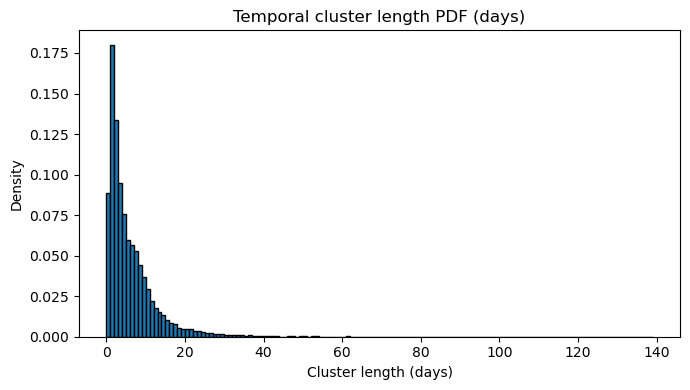

In [16]:
lengths = collect_temporal_cluster_lengths(split_results, label_col="temporal_cluster")

# quick stats (optional)
if not lengths.empty:
    desc = {
        "count": int(lengths.size),
        "min": int(lengths.min()),
        "p05": float(np.percentile(lengths, 5)),
        "median": float(np.median(lengths)),
        "p95": float(np.percentile(lengths, 95)),
        "max": int(lengths.max()),
        "mean": float(lengths.mean())
    }
    print("Temporal cluster length stats (days):", desc)

plot_cluster_length_pdf(lengths, bins='auto')

In [28]:
# ---- Use the helpers to annotate the original claims ----
temp_map = assemble_temporal_labels(split_results, temp_col="temporal_cluster")
st_map   = assemble_final_st_labels(combined_frames, st_col="st_final")

claims_with_clusters = (
    claims
    .merge(temp_map, on='index', how='left')
    .merge(st_map,   on='index', how='left')
)

# Fill missing labels with -1 and set compact dtypes
claims_with_clusters['temporal_cluster'] = (
    claims_with_clusters['temporal_cluster'].fillna(-1).astype('int32')
)
claims_with_clusters['st_final'] = (
    claims_with_clusters['st_final'].fillna(-1).astype('int32')
)

# Quick sanity prints
n = len(claims_with_clusters)
print(f"Annotated {n} rows.")
print(
    f"Temporal clusters present on { (claims_with_clusters['temporal_cluster']>=0).sum() } rows "
    f"({ (claims_with_clusters['temporal_cluster']>=0).mean():.1%})."
)
print(
    f"Final ST clusters present on { (claims_with_clusters['st_final']>=0).sum() } rows "
    f"({ (claims_with_clusters['st_final']>=0).mean():.1%})."
)

Annotated 2038733 rows.
Temporal clusters present on 1885794 rows (92.5%).
Final ST clusters present on 128572 rows (6.3%).


# County Analysis

In [5]:
claims, sensitivities = sensitivity_analysis(claims, space_thres_list, time_thres_list, num_thres_list)

Temporal clustering completed in 377.80 seconds.
Spatio-temporal clustering completed in 5.73 seconds.


/home/jovyan/2_Low_Return_Period/ST_Cluster.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unclustered_temporal_clusters['new_cluster'] = range(max_st_cluster + 1, max_st_cluster + 1 + len(unclustered_temporal_clusters))


Merging clusters completed in 15.87 seconds.
Total clusters: 7045
Percentage of unclustered claims: 7.50%


In [6]:
if save:
    # Save the sensitivity analysis
    sensitivities.to_csv(f'{temp_folder}/cluster_sensitivities_cl.csv', index=False)

    # Save the clustered claims
    claims.to_csv(f"{temp_folder}/clustered_claims_sensitivity.csv", index=False)

In [7]:
if save_small:
    claims[['id','dateOfLoss','longitude','latitude','st_cluster_3_5_7']].to_csv(f"{temp_folder}/clustered_claims_export.csv", index=False)